<a href="https://colab.research.google.com/github/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %%timeit
# !pip install ipython-autotime
# %load_ext autotime
# %unload_ext autotime

from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [0]:
class Maze:
  V_WALL = 3
  V_START = 1
  V_GOAL = 2
  FONTSIZE = 18
  LEFT = '←'
  RIGHT = '→'
  UP = '↑'
  DOWN = '↓'
  REWARD = -1
  REWARD_GOAL = 50

  def __init__(self, width=9, height=6):
    self.countDraw = 0
    self.shape = (height, width)
    self.mkMaze()
    self.initSAP()
    self.mkPlt()

  def initSAP(self):
    gridStates = list(np.ndindex(self.shape))
    self.states = list(np.ndindex(self.shape))
    [self.states.remove(wall) for wall in self.wall_indexlist]
    [self.states.remove(goal) for goal in self.goal_indexlist]
    self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
    self.actionSymbols = dict(zip(self.actions, [self.LEFT, self.RIGHT, self.UP, self.DOWN]))
    self.actionSymbolsRev = dict(zip([self.LEFT, self.RIGHT, self.UP, self.DOWN], self.actions))

    self.policy = {}
    self.value = {}

    for s in gridStates: #list(np.ndindex(self.shape)):
      self.value[s] = 0
    # print(self.value[tuple(self.goal_indexlist[0])])
    
    for s in self.states:
      canActionList = self.supposeAction(s)
      numAction = len(canActionList)
      for alist in canActionList:
        a = alist[0]
        self.policy[(s,a)] = 1/numAction
    # for keys,values in self.policy.items(): print(keys, values)

  def supposeAction(self, s):
    canActionList = []
    reward = self.REWARD
    for a in self.actions:
      s_new = tuple(np.asarray(s) + np.asarray(a)[::-1])
      canAction = s_new in self.states
      canGoal = s_new == tuple(self.goal_indexlist[0])
      if canGoal: reward = self.REWARD_GOAL
      if canAction or canGoal: canActionList.append([a, reward, s_new])

    return canActionList

  def chooseAction(self, s):
    chooseActionList = []
    canActionList = self.supposeAction(s)
    for alist in canMoveList:
      a = alist[0]
      # self.policy[(s,a)] = 1/len(canMoveList)


  def mkPlt(self):
    # make a color map of fixed colors
    self.cmap = colors.ListedColormap(['white', 'yellow', 'grey'])
    bounds=[0.5, 1.5, 2.5, 9.5]
    self.norm = colors.BoundaryNorm(bounds, self.cmap.N)

    self.fig, (self.ax, self.ax2) = plt.subplots(1,2, figsize=(15, 5))
    # fig, (self.ax) = plt.subplots()#(2,1) #1, figsize=(9, 6))
  
    self.ax.set_xticks([])
    self.ax.set_yticks([])
    self.ax.axis('on')
    self.ax.spines['left'].set_linewidth(0.5)
    self.ax.spines['right'].set_linewidth(0.5)
    self.ax.spines['top'].set_linewidth(0.5)
    self.ax.spines['bottom'].set_linewidth(0.5)
    self.ax.spines['left'].set_color('k')
    self.ax.spines['right'].set_color('k')
    self.ax.spines['top'].set_color('k')
    self.ax.spines['bottom'].set_color('k')
    # self.ax.spines['left'].set_visible(False)
    # self.ax.spines['right'].set_visible(False)
    # self.ax.spines['top'].set_visible(False)
    # self.ax.spines['bottom'].set_visible(False)

  def mkMaze(self):
    self.maze = np.zeros(self.shape, dtype=int)

    # Mark location
    self.maze[3,0] = self.V_START
    self.maze[5,8] = self.V_GOAL

    # Mark wall for maze
    self.maze[2:5,2] = self.V_WALL
    self.maze[1,5] = self.V_WALL
    self.maze[3:6,7] = self.V_WALL

    self.wall_index = np.where(self.maze == self.V_WALL)
    self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

    self.goal_index = np.where(self.maze == self.V_GOAL)
    self.goal_indexlist = list(zip(self.goal_index[0], self.goal_index[1]))
    # print(self.wall_index)

  def isWall(self, state):
    if self.maze[state] == self.V_WALL:
      return True
    else:
      return False

  def isGoal(self, state):
    if self.maze[state] == self.V_GOAL:
      return True
    else:
      return False 

  def setMaze(self):
    self.ax.pcolor(self.maze,snap='true', edgecolors='k', linewidths=0.5, cmap=self.cmap, norm=self.norm)

    self.ax.text(0.5, 3.5, 'S', fontsize=self.FONTSIZE, ha='center', va='center')
    self.ax.text(8.5, 5.5, 'G', fontsize=self.FONTSIZE, ha='center', va='center')
    self.ax.text(4.5, 4.5, '■', fontsize=self.FONTSIZE, ha='center', va='center')

  def setAction(self):
    argActionLeft = dict(fontsize=self.FONTSIZE, ha='right', va='center', color='deepskyblue')
    argActionRight = dict(fontsize=self.FONTSIZE, ha='left', va='center', color='deepskyblue')
    argActionUp = dict(fontsize=self.FONTSIZE, ha='center', va='bottom', color='deepskyblue')
    argActionDown = dict(fontsize=self.FONTSIZE, ha='center', va='top', color='deepskyblue')
    argAction = dict(zip(self.actions, [argActionLeft, argActionRight, argActionUp, argActionDown]))

    for s in self.states:
      if self.isWall(s): continue
      j = s[0] + 0.5
      i = s[1] + 0.5
      for a in self.actions:
        try:
          policy = self.policy[(s, a)]
        except KeyError:
          continue
        if policy <= 0: continue
        actionSymbol = self.actionSymbols[a]
        arg = argAction[a]
        self.ax.text(i, j, actionSymbol, **arg)

  def setValue(self):
    value = np.zeros(self.shape)
    for s in self.value.keys():
      value[s] = self.value[s]

    pc = self.ax2.pcolor(value, snap='true', edgecolors='w', linewidths=0.5)
    pc.update_scalarmappable()
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
      x, y = p.vertices[:-2, :].mean(0)
      red, green, blue = color[:3]*255
      brightness = (red*0.299 + green*0.587 + blue*0.114) > 186
      color = 'k' if brightness else  'w'
      self.ax2.text(x, y, str(round(value, 2)), ha="center", va="center", color=color)

  def draw(self):
    self.ax.cla()
    self.ax2.cla()
    self.countDraw += 1
    self.setMaze()
    self.setAction()
    self.setValue() 
    plt.show() if self.countDraw == 1 else display(self.fig)
    # if self.countDraw > 1: display(self.fig)

  def getmaze(self):
    print(self.maze)
    return self.maze




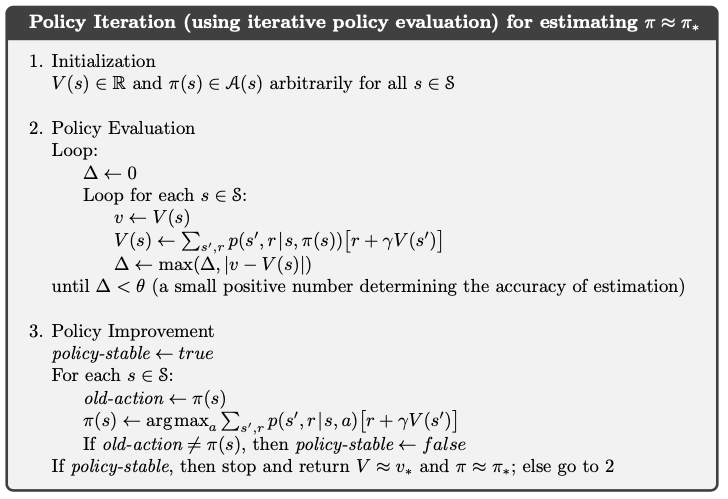

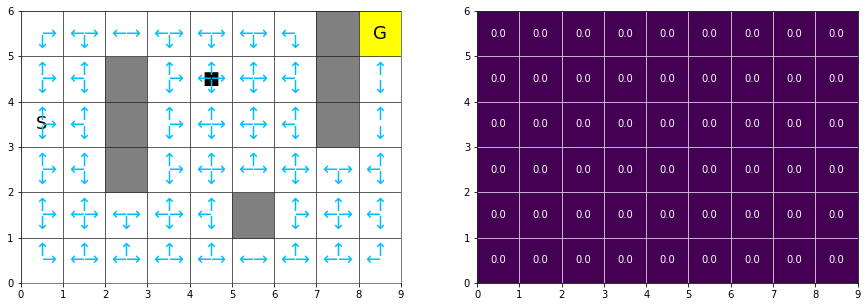

(1, 0) -9.886721055966717
(0, 1) -9.932830314099125
(0, 0) {(1, 0)} -8.898048950370045


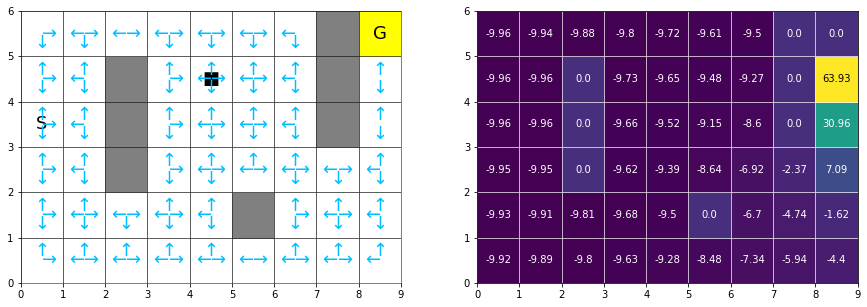

In [464]:
# %load_ext autotime
# %unload_ext autotime

def policyEvaluate(maze, reward_decline=0.9, convergence_thold=1e-5):
  while True:
    for s in maze.states:
      v_old = maze.value[s]
      v_new = 0
      canActionList = maze.supposeAction(s)
      for alist in canActionList:
        a, reward, s_new = alist
        v_new += maze.policy[(s,a)] * (reward + reward_decline * maze.value[s_new])
      maze.value[s] = v_new
      error = abs(v_new - v_old)

    if error < convergence_thold:
      break

def policyImprovement(maze, reward_decline=0.9):
  while True:
    policyStable = True
    q = {}
    for s in maze.states:
      canActionList = maze.supposeAction(s)
      for alist in canActionList:
        a, reward, s_new = alist
        a_old = a
        policy_old = maze.policy[(s, a)]
        q[a] = reward_decline * maze.value[s_new]
        print(a, maze.value[s_new])
      qmax_value = max(q.values())

      qmax = {key for key, value in q.items() if value == qmax_value}
      # a_new =
      print(s, qmax, qmax_value)
      return

maze = Maze()
maze.draw()
policyEvaluate(maze)
# print(maze.value[(1,0)])
policyImprovement(maze)
maze.draw()